## Configure the notebook

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#cd content/drive/My\ Drive/Code/Visual_Question_Answering/
cd drive/My\ Drive/Code/Visual_Question_Answering/

/content/drive/My Drive/Code/Visual_Question_Answering


In [0]:
ls

## Load the data

In [0]:
import pandas as pd

## read the csv files with the data

train_dir='./data/processed_data/DAQUAR_train_processed.csv'
test_dir='./data/processed_data/DAQUAR_test_processed.csv'

data_train=pd.read_csv(train_dir)
data_test=pd.read_csv(test_dir)

In [0]:
#lets take a look at our data 

data_train

,question,image,answer
0,['﻿what is on the right side of the black tele...,3,['desk']
1,['what is in front of the white door on the le...,3,['telephone']
2,['what is on the desk in the '],3,['book scissor papers tape_dispenser']
3,['what is the largest brown objects in this '],3,['carton']
4,['what color is the chair in front of the whit...,3,['red']
...,...,...,...
6790,['what are stuck on the wall in the '],1440,['photo']
6791,['what is in the top right corner in the '],1440,['window']
6792,['what is in front of the window in the '],1440,['cabinet']
6793,['what are the things on the cabinet in the '],1440,['candelabra book']


## Tokenization of the text

In [0]:
# Make sure that our version of tensorflow is not 2.0
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from keras.preprocessing.text import Tokenizer

#create an instance of class Tokenizer
MAX_WORDS = 3000
tokenizer = Tokenizer(num_words = MAX_WORDS, split=' ')

#has to fit on questions and answers of the train dataset only
tokenizer.fit_on_texts(data_train['question'])
tokenizer.fit_on_texts(data_train['answer'])

1.15.0


Using TensorFlow backend.


In [0]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences 
import numpy as np

def tokenization(tokenizer, length_of_sequence, dataset, multiple_answer=True):
    MAX_LEN=length_of_sequence

    seqs_question = tokenizer.texts_to_sequences(dataset['question'])
    seqs_answer = tokenizer.texts_to_sequences(dataset['answer'])

    #when you pad as 'post' you will remove the words at the end of the sentence if too long, and not at the start
    #of the sentence.
    pad_seqs_question = pad_sequences(seqs_question,MAX_LEN,truncating='post')
    pad_seqs_answer = pad_sequences(seqs_answer,MAX_LEN,truncating='post')

    #we choose if we want to keep one or multiple answers
    if multiple_answer is False:
        pad_seqs_answer_one_answer = pad_seqs_answer[:,[MAX_LEN-1]]
        return pad_seqs_question, dataset['image'], pad_seqs_answer_one_answer

    else:
        return pad_seqs_question, dataset['image'], pad_seqs_answer

In [0]:
#we set the max number of words in each questin to 25, if less than 25 there will be padding (zeros)
MAX_LEN=25

### TRAINING SET ####
train_questions,train_images,train_answers = tokenization(tokenizer, MAX_LEN, data_train, multiple_answer=False)
test_questions,test_images,test_answers = tokenization(tokenizer, MAX_LEN, data_test, multiple_answer=False)

In [0]:
import numpy as np

#this method allows us to transform our list of indices to an actual list of one hot vectors.
#this is needed only for the output of the model as the keras embedding layer can already take indices as input
def from_index_to_one_hot(index_sequence,MAX_WORDS):
  #create an empty array of size (6795, 25, 3000)
  one_hot_array=np.zeros((len(index_sequence),len(index_sequence[0]),MAX_WORDS))
  for i in range(len(index_sequence)):
    for j in range(len(index_sequence[0])):
      index = index_sequence[i,j]
      #write 1 at the location of the index
      one_hot_array[i,j,index]=1
  
  return one_hot_array

In [0]:
#max number of words in the vocabulary will be 3000, this also means that one hot encoding of words
#will be of length 3000
MAX_WORDS=3000

one_hot_array=from_index_to_one_hot(train_questions,MAX_WORDS)

## Text Autoencoder

### Biredectional LSTM model with custom word embedding

In [0]:
from keras.models import Sequential
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import Embedding
from keras.layers import TimeDistributed
from keras.utils import plot_model

EMBEDDING=300
# encoder input model
inputs = Input(shape=(MAX_LEN,))
encoder1 = Embedding(MAX_WORDS, EMBEDDING)(inputs)
encoder2  = Bidirectional(LSTM(512,activation='relu'))(encoder1)
#ENCODER MODEL
#make sure to create an model inside your model. Because the encoder will be 
#saved as a model itself.
encoder_model = Model(inputs=inputs,outputs=encoder2, name='Encoder')
encoder_output=encoder_model(inputs)

# decoder output model
decoder1 = RepeatVector(MAX_LEN)(encoder_output)
decoder2= Bidirectional(LSTM(512, return_sequences=True,activation='relu'))(decoder1)
outputs = TimeDistributed(Dense(MAX_WORDS, activation='softmax'))(decoder2)

# tie it together
lstm_autoencoder_model = Model(inputs=inputs, outputs=outputs)
lstm_autoencoder_model.compile(loss='categorical_crossentropy', optimizer='adam')

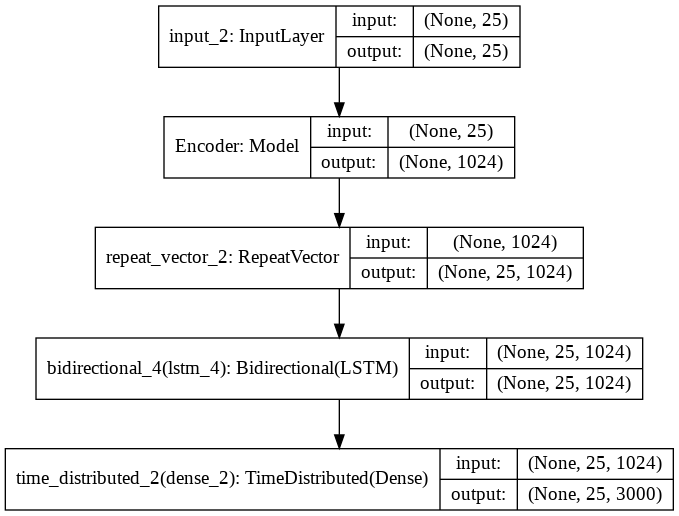

In [0]:
import os
#create a directory for the models
os.makedirs('models',exist_ok=True)

plot_model(lstm_autoencoder_model,show_layer_names=True,show_shapes=True, to_file='./models/bidirectionnal_lstm_autoencoder1.png')

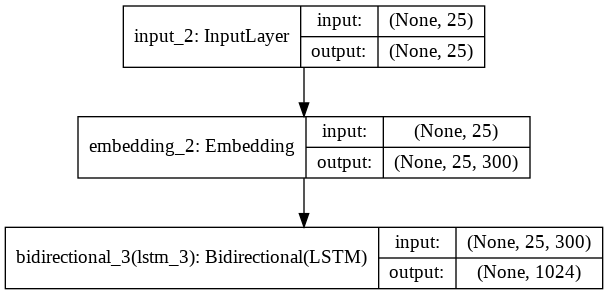

In [0]:
plot_model(encoder_model,show_layer_names=True,show_shapes=True, to_file='./models/bidirectionnal_lstm_encoder1.png')

### Training

In [0]:
from keras.callbacks import EarlyStopping

sequence = train_questions.reshape((-1, MAX_LEN))

#if the validation loss does not get new best after 5 epochs, we stop the training to avoid too much overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# fit model
history=lstm_autoencoder_model.fit(sequence,
          one_hot_array,
          batch_size=32,
          epochs=50,
          verbose=1, 
          validation_split=0.12,
          callbacks=[es]
          )

Train on 5979 samples, validate on 816 samples
Epoch 1/50
5979/5979 [==============================] - 66s 11ms/step - loss: 1.8487 - val_loss: 0.9720
Epoch 2/50
5979/5979 [==============================] - 61s 10ms/step - loss: 0.9879 - val_loss: 0.7644
Epoch 3/50
5979/5979 [==============================] - 61s 10ms/step - loss: 0.8290 - val_loss: 0.6807
Epoch 4/50
5979/5979 [==============================] - 61s 10ms/step - loss: 1.0946 - val_loss: 0.8229
Epoch 5/50
5979/5979 [==============================] - 61s 10ms/step - loss: 0.8401 - val_loss: 0.7572
Epoch 6/50
5979/5979 [==============================] - 60s 10ms/step - loss: 0.7332 - val_loss: 0.8221
Epoch 7/50
5979/5979 [==============================] - 61s 10ms/step - loss: 0.6395 - val_loss: 0.5558
Epoch 8/50
5979/5979 [==============================] - 61s 10ms/step - loss: 0.6897 - val_loss: 1.0211
Epoch 9/50
5979/5979 [==============================] - 60s 10ms/step - loss: 0.5844 - val_loss: 0.4560
Epoch 10/50
5979/

### Visualization

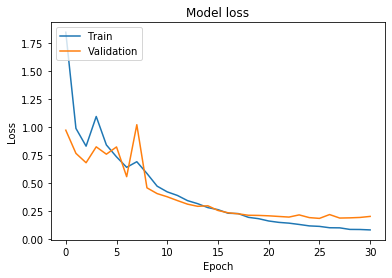

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
#save model weights

lstm_autoencoder_model.save_weights('./models/bidirectionnal_lstm_autoencoder1.h5')
encoder_model.save_weights('./models/bidirectionnal_lstm_encoder1.h5')

### Results: Compare reconstructed sentences

In [0]:
#method to get the english text back from the indices
def get_text(sentence_to_decode, tokenizer):
  reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
  sentence=[]
  for j in range(len(sentence_to_decode)):
      t=sentence_to_decode[j]
      try:
          sentence.append(reverse_word_map[t])

      except:

          pass

  return(sentence)

In [0]:
#make predicitons on the test set
decoded_predictions=lstm_autoencoder_model.predict(test_questions)
#use argmax to get the index with the highest probability
decoded_predictions_argmax=np.argmax(decoded_predictions, axis=2)

In [0]:
for index in range(20,30):
  print('')
  print('real:')
  for word in range(len(get_text(test_questions[index],tokenizer))):
    print(get_text(test_questions[index],tokenizer)[word],end=' ')
  print('')
  print('prediction:')
  for word in range(len(get_text(decoded_predictions_argmax[index],tokenizer))):
    print(get_text(decoded_predictions_argmax[index],tokenizer)[word],end=' ')


real:
'what is on the wall on the left side of the door and on the right side of the picture in the ' 
prediction:
on on on side side of of the the the the the and on the right side of the pot in the ' 
real:
'what color is the door on the right side of the corridor in the ' 
prediction:
'what is the found on the right side of the mirror in the ' 
real:
'how many ceiling lamps are on in the corridor in the ' 
prediction:
'how many many lamps are reflected in the desk in the ' 
real:
'what is the smallest black object on the table below the bookshelf in the ' 
prediction:
'what is the white black object on the ground on the bookshelf in the ' 
real:
'what is the white object on the table on the right side of the wall below the bookshelf in the ' 
prediction:
'what is object object object the the side of the the the the right on the bookshelf in the ' 
real:
'what is in front of the wall on the left side of the picture in the ' 
prediction:
'what in in of the the wall on the left side o